|        |        |        |
|--------|--------|--------|
![H-BRS](logos/h-brs.png) | ![A2S](logos/a2s.png) | ![b-it](logos/b-it.png) |

# Autonomous Mobile Robots

# AMR Assignment 6

### General information

* Please do not add or delete any cells. Answers belong into the already provided cells (below the question).
* If a function is given (either as a signature or a full function), you should not change the name, arguments, or return value of the function.
* If you encounter empty cells underneath the answer that can not be edited, please ignore them; they are for testing purposes.
* Please note that variables declared in the notebook cells have global scope. To make sure your assignment works correctly as a whole, please restart the kernel and run all cells before submitting (e.g. via *Kernel -> Restart & Run All*).
* Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. Once you fill out a function, please delete this line.

### Submission

Please make sure to write all your team members 2s IDs in the cell below before submission. Please submit your notebook via the JupyterHub web interface (in the main view -> Assignments -> Submit). If it is a group assignment, please make only one submission per group (for easier bookkeeping, it is best if this is always the same team member).

### Questions about the assignment

If you have questions about the assignment, you are encouraged to post them in the LEA forum. Proactive discussions lead to better understanding. Let's keep the forum active.

## Team members (2s IDs):

YOUR ANSWER HERE

*anuhel2s

*mkhan2s

*spatha2s

## Occupancy Grid Mapping [100 points]

As discussed in the lecture, environment representations used for navigation and path planning are referred to as maps. One variant of these is the metric map, in which the geometric details from the environment serve as the constituents of the map, represented either continuously or discretely.

An occupancy grid is a discrete map representation where each grid cell is a binary random variable representing the probability of occupancy of the respective region of the environment. In this assignment, you will implement the 2D occupancy grid mapping algorithm, assuming negligible noise in the odometry, but significant noise in the laser scan data. Thus, we are not dealing with a SLAM problem, but rather aim to create a map by assuming perfect localisation and by handling noise in the laser scan data.

### Tasks

- Run the Robile in simulation and map the complete `closed_walls.world` environment.
- Simultaneously publish the map to the `/map` topic with a message type of `nav_msgs/msg/OccupancyGrid`.
- Take a keyboard interruption to trigger stopping and saving of the map.
- Save the map as a `.png` image once mapping is terminated.

### Parameters

- Map size: $20 x 20m$
- Map resolution: $0.1m$
- $P_{prior} = 0.5$ (prior probability of occupancy before a laser ray hits or passes through a cell)
- $P_{occ} = 0.1$ (probability value assigned when a cell is determined to be occupied by the inverse sensor model)
- $P_{free} = 0.8$ (probability value assigned when a cell is determined to be free by the inverse sensor model)
- $threshold_{p_{free}} = 0.7$ (probability threshold for a cell to be considered free when rendering the map image)
- $threshold_{p_{occ}} = 0.4$ (probability threshold for a cell to be considered occupied when rendering the map image)

### Assumptions

- The environment remains static over time.
- The odometry data is accurate, so it is not required to account for noise in the control commands.
- Each grid cell value is treated as an independent binary random variable.
- The standard deviation of the Gaussian noise added to the scan data is $0.001$. You can modify this by updating the standard deviation value in line 28 of the `hokuyo_urg04_laser.gazebo.xacro` file located in the `robile_description/urdf/sensors` directory.

### Hints

- The inverse sensor model determines which cells should be assigned probabilities of being occupied, free, or unknown by considering the field of view and a distance tolerance.
- From the algorithm on `slide 11` from lecture, the prior log odds ($l_o$) will be zero, as P_prior is 0.5.
- To handle the edge case where a cell is being partially occupied by an obstacle, consider updating all free cells after ray tracing (the process of determining which cells are in field of view of laser scanner) followed by the occupied cell.
- After terminating the mapping, if the log odds of a cell are lower than $threshold_{p_{occ}}$, then the value can be capped at $0.01$. Similarly, if the log odds of a cell are greater than $threshold_{p_{free}}$, then the value can be capped at $0.99$ to avoid accumulation of the log odds. To handle the same situation during mapping, the values can be capped as well.
- To avoid accumulation of the log likelihood values, perform a map update only when the robot is moved by a certain threshold distance or by a certain threshold angle.

### Deliverables

- Paste your complete mapping node in the cell below.
- In the cell further below, include screenshots that verify the correctness of your implementation.

### Potentially useful references

* https://www.cs.cmu.edu/~16831-f14/notes/F14/16831_lecture06_agiri_dmcconac_kumarsha_nbhakta.pdf

In [ ]:
# YOUR CODE HERE
import rclpy
from rclpy.node import Node
from nav_msgs.msg import OccupancyGrid, Odometry
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Pose, Point, Quaternion, Twist
import numpy as np
from PIL import Image
import math
import threading

class MappingNode(Node):
    def __init__(self):
        super().__init__('occupancy_grid_mapper')

        # Map parameters
        self.map_size = 20  # meters
        self.map_resolution = 0.1  # meters
        self.width = int(self.map_size / self.map_resolution)
        self.height = int(self.map_size / self.map_resolution)

        # Initialize log-odds map
        self.log_odds_map = np.zeros((self.width, self.height))

        # Parameters
        self.p_prior = 0.5
        self.p_occ = 0.1
        self.p_free = 0.8
        self.threshold_p_free = 0.7
        self.threshold_p_occ = 0.4

        # Log odds
        self.log_odds_prior = math.log(self.p_prior / (1 - self.p_prior))
        self.log_odds_occ = math.log(self.p_occ / (1 - self.p_occ))
        self.log_odds_free = math.log(self.p_free / (1 - self.p_free))

        # Initialize occupancy grid message
        self.occupancy_grid = OccupancyGrid()
        self.occupancy_grid.header.frame_id = "map"
        self.occupancy_grid.info.resolution = self.map_resolution
        self.occupancy_grid.info.width = self.width
        self.occupancy_grid.info.height = self.height
        self.occupancy_grid.info.origin = Pose(position=Point(x=-self.map_size / 2, y=-self.map_size / 2, z=0.0),
                                               orientation=Quaternion(x=0.0, y=0.0, z=0.0, w=1.0))

        # ROS publishers and subscribers
        self.subscription = self.create_subscription(LaserScan, '/scan', self.laser_callback, 10)
        self.odom_sub = self.create_subscription(Odometry, '/odom', self.odom_callback, 10)
        self.publisher_ = self.create_publisher(OccupancyGrid, '/map', 10)
        self.cmd_pub = self.create_publisher(Twist, '/cmd_vel', 10)
        self.timer = self.create_timer(0.5, self.publish_map)

        # Robot pose
        self.robot_x = self.map_size / 2
        self.robot_y = self.map_size / 2
        self.robot_theta = 0.0  # Orientation in radians

        # Thread for keyboard interruption
        self.stop_mapping = False
        threading.Thread(target=self.listen_for_stop).start()

    def laser_callback(self, msg):
        angles = np.arange(msg.angle_min, msg.angle_max, msg.angle_increment)
        for angle, distance in zip(angles, msg.ranges):
            if msg.range_min < distance < msg.range_max:
                hit_x = self.robot_x + distance * math.cos(self.robot_theta + angle)
                hit_y = self.robot_y + distance * math.sin(self.robot_theta + angle)
                self.update_log_odds(self.robot_x, self.robot_y, hit_x, hit_y, distance)

    def odom_callback(self, msg):
        # Update robot pose from odometry
        self.robot_x = msg.pose.pose.position.x + self.map_size / 2
        self.robot_y = msg.pose.pose.position.y + self.map_size / 2
        orientation = msg.pose.pose.orientation
        _, _, self.robot_theta = self.euler_from_quaternion(
            [orientation.x, orientation.y, orientation.z, orientation.w]
        )

    def euler_from_quaternion(self, quat):
        # Convert quaternion to Euler angles
        x, y, z, w = quat
        t0 = 2.0 * (w * x + y * z)
        t1 = 1.0 - 2.0 * (x * x + y * y)
        roll = math.atan2(t0, t1)

        t2 = 2.0 * (w * y - z * x)
        t2 = 1.0 if t2 > 1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch = math.asin(t2)

        t3 = 2.0 * (w * z + x * y)
        t4 = 1.0 - 2.0 * (y * y + z * z)
        yaw = math.atan2(t3, t4)

        return roll, pitch, yaw

    def update_log_odds(self, x0, y0, x1, y1, distance):
        x0_idx = int(x0 / self.map_resolution)
        y0_idx = int(y0 / self.map_resolution)
        x1_idx = int(x1 / self.map_resolution)
        y1_idx = int(y1 / self.map_resolution)

        free_cells = self.bresenham(x0_idx, y0_idx, x1_idx, y1_idx)

        for (x, y) in free_cells:
            if 0 <= x < self.width and 0 <= y < self.height:
                self.log_odds_map[x, y] += self.log_odds_free - self.log_odds_prior

        if 0 <= x1_idx < self.width and 0 <= y1_idx < self.height:
            self.log_odds_map[x1_idx, y1_idx] += self.log_odds_occ - self.log_odds_prior

    def bresenham(self, x0, y0, x1, y1):
        """ Bresenham's Line Algorithm """
        cells = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            cells.append((x0, y0))
            if x0 == x1 and y0 == y1:
                break
            e2 = err * 2
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy

        return cells

    def publish_map(self):
        self.occupancy_grid.data = [self.probability_to_occupancy(p) for p in self.log_odds_map.flatten()]
        self.publisher_.publish(self.occupancy_grid)

    def probability_to_occupancy(self, log_odds):
        if log_odds < math.log(self.threshold_p_free / (1 - self.threshold_p_free)):
            return 0
        elif log_odds > math.log(self.threshold_p_occ / (1 - self.threshold_p_occ)):
            return 100
        else:
            return -1

    def save_map(self, filename="map.png"):
        data = np.array(self.occupancy_grid.data).reshape((self.width, self.height))
        img_data = np.zeros((self.width, self.height, 3), dtype=np.uint8)

        img_data[data == 0] = [255, 255, 255]  # Free cells
        img_data[data == 100] = [0, 0, 0]  # Occupied cells
        img_data[data == -1] = [128, 128, 128]  # Unknown cells

        img = Image.fromarray(img_data, 'RGB')
        img.save(filename)

    def listen_for_stop(self):
        input("Press Enter to stop mapping...")
        self.stop_mapping = True
        self.save_map('map.png')
        self.destroy_node()
        rclpy.shutdown()

def main(args=None):
    rclpy.init(args=args)

    mapping_node = MappingNode()

    try:
        while not mapping_node.stop_mapping:
            # Robot movement (basic exploration pattern)
            move = Twist()
            move.linear.x = 0.2  # Move forward
            move.angular.z = 0.1  # Rotate slightly
            mapping_node.cmd_pub.publish(move)
            rclpy.spin_once(mapping_node, timeout_sec=0.1)
    except KeyboardInterrupt:
        mapping_node.save_map('map.png')
    finally:
        mapping_node.destroy_node()
        rclpy.shutdown()

if __name__ == '__main__':
    main()


Include screenshots that verify your implementation here.

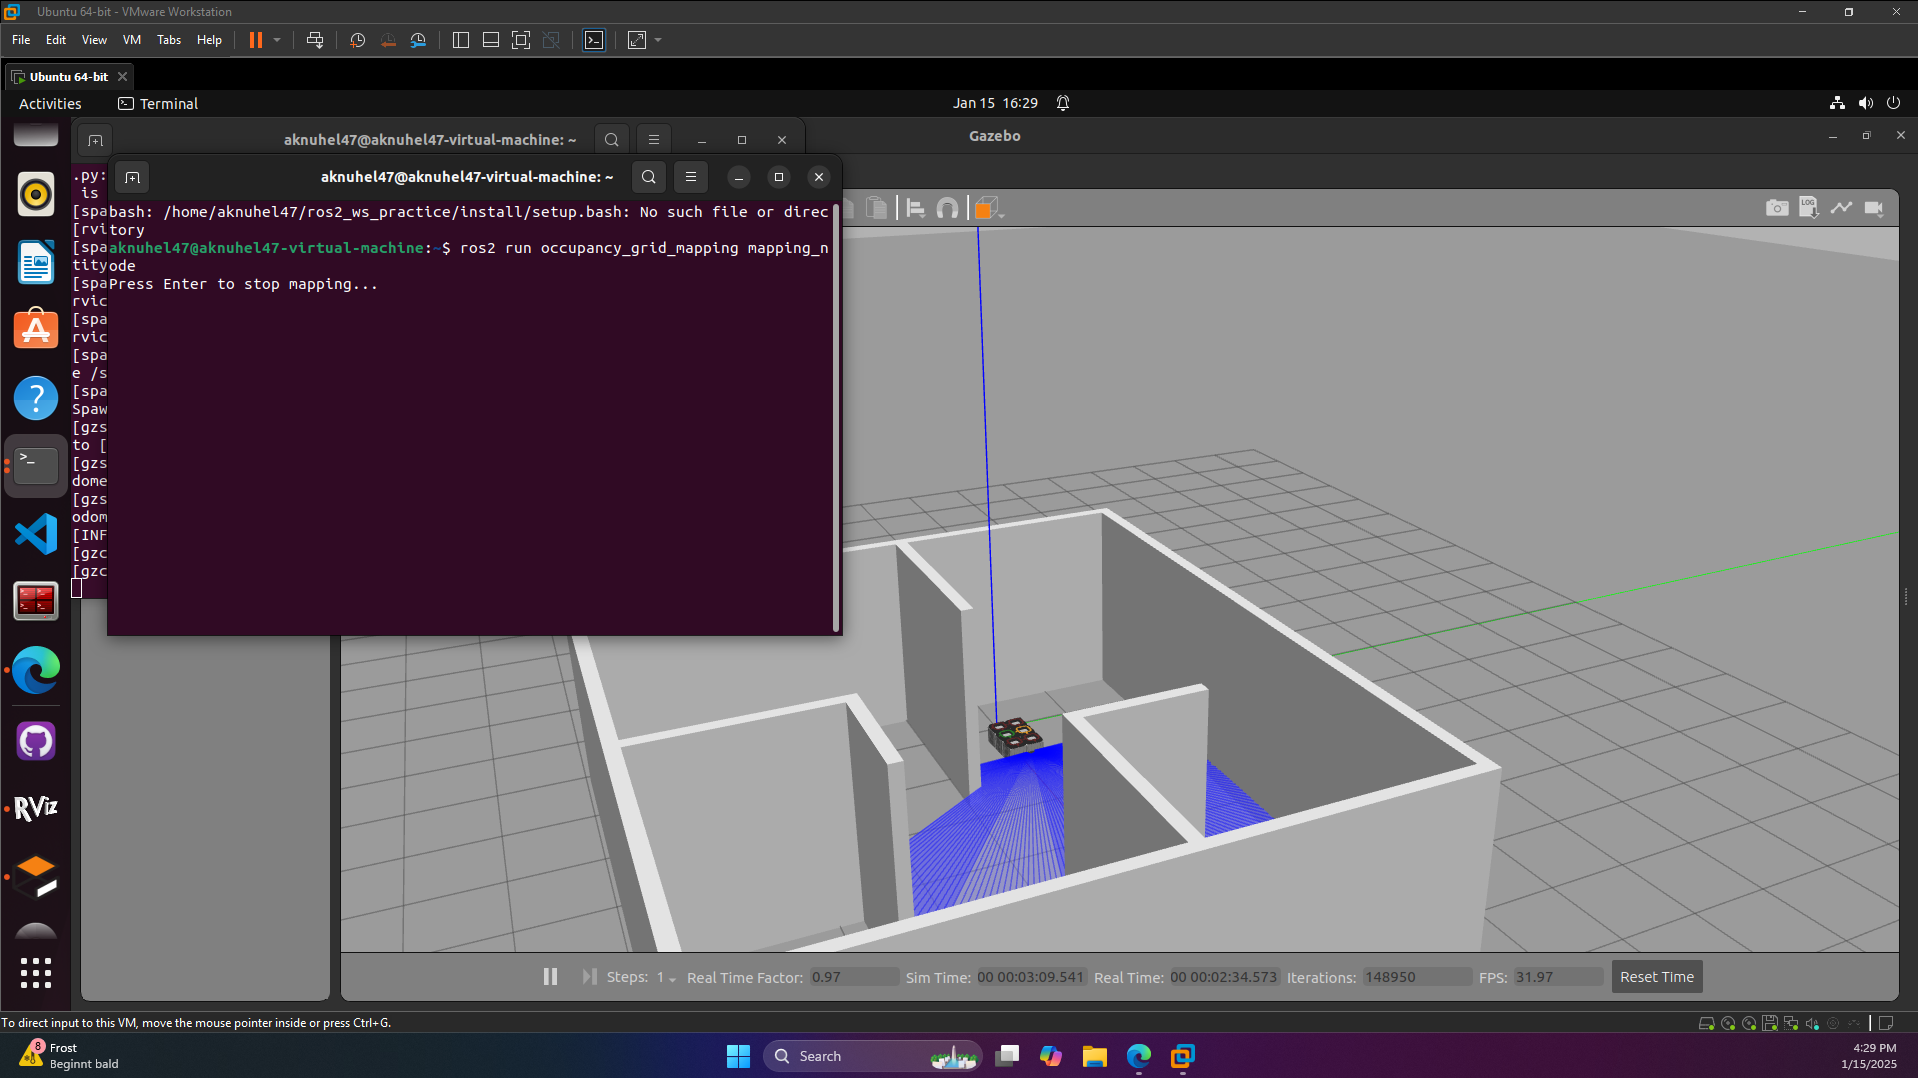
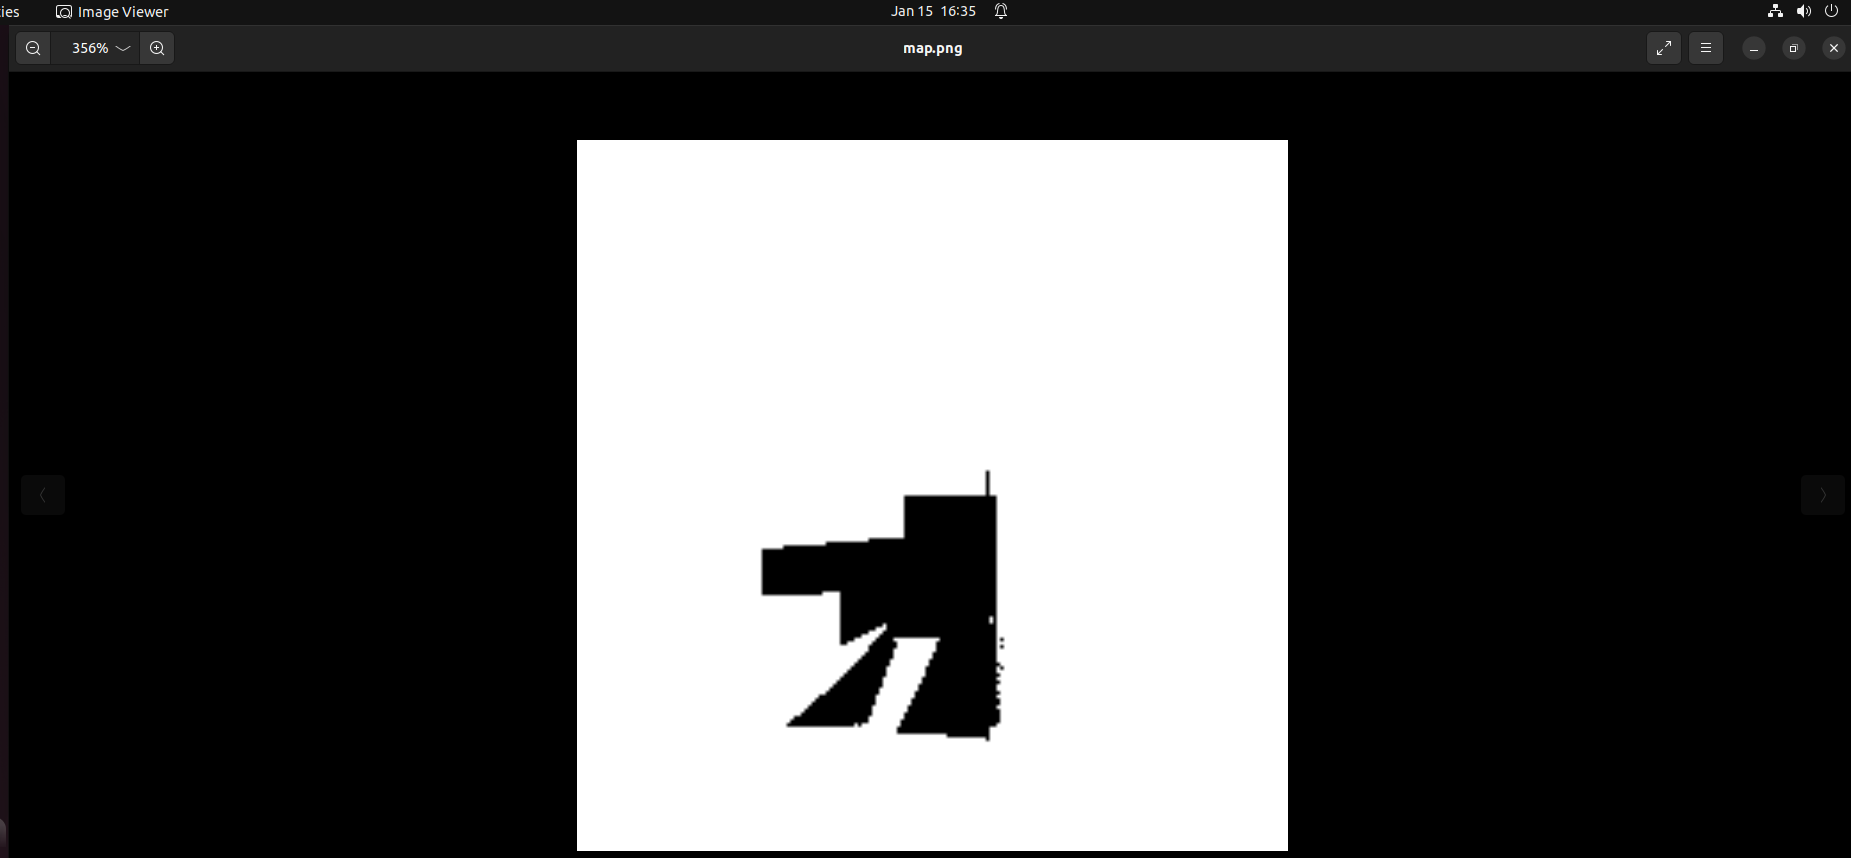